# Convolutional Neural Networks

### Designing and training a CNN from scratch

In this notebook, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 50%.

Although 50% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="static_images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 50% is significantly better than random guessing, which would provide an accuracy of just 2% (100% / 50 classes).

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly, download the data if you don't have it already, and also check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
!pip install -r requirements.txt | grep -v 'already satisfied'

In [27]:
import src.helpers as helpers
from importlib import reload
reload(helpers)

helpers.setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


In [25]:
!pytest -vv src/data.py -k data_loaders

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 4 items / 1 deselected / 3 selected

src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

============================== warnings summary ===============================
..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instea

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> **Answer**: My code first resizes the image to 256 and then crops to 224. I picked 224 as the input size because it is the recommended input size for using pytorch's pre-trained models. I did decide to augment the dataset via RandAugment, a typical set of augmentations for natural images. I added this augmentation with the goal of improving my model's robustness, thus improving test accuracy.

### Visualize a Batch of Training Data

In [27]:
!pytest -vv src/data.py -k visualize_one_batch

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 4 items / 3 deselected / 1 selected

src/data.py::test_visualize_one_batch PASSED                             [100%]

============================== warnings summary ===============================
..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
    interpolation: int = Image.BILINEAR,

..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:286
  C:\

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


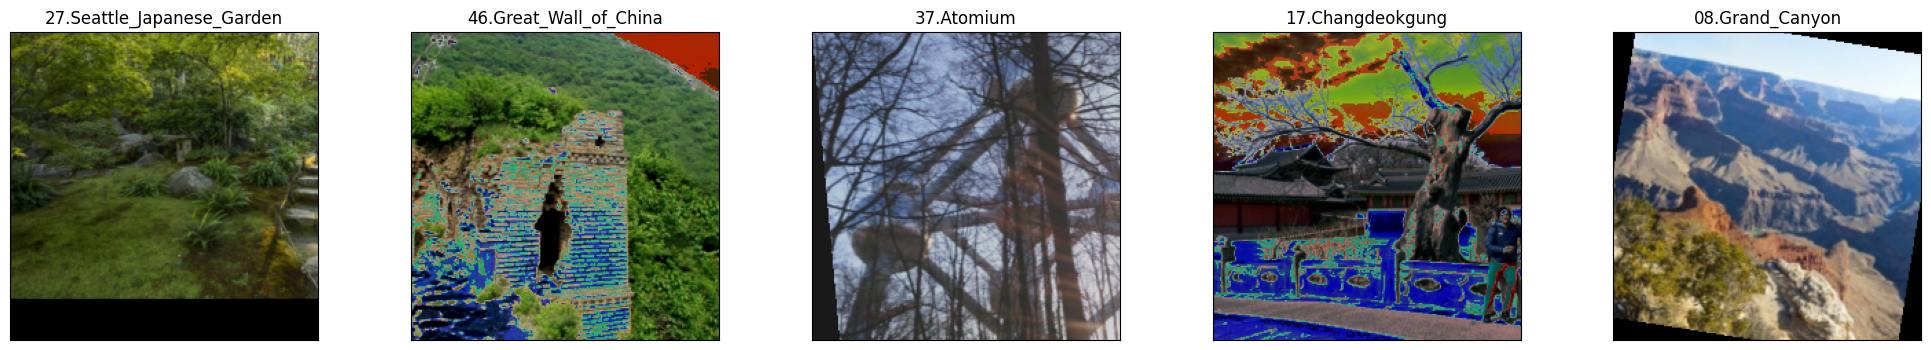

In [2]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=-1)

visualize_one_batch(data_loaders)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Define model

In [29]:
!pytest -vv src/model.py

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 1 item

src/model.py::test_model_construction PASSED                             [100%]

============================== warnings summary ===============================
src/model.py::test_model_construction
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
    interpolation: int = Image.BILINEAR,

src/model.py::test_model_construction
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:286: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> __Answer:__ 
- I used 3 convolutional layers so that my model could be sufficiently expressive.
- I used dropout layers to reduce my model's tendency to overfit the training data.
- I used batch normalization to make the optimization faster
- I used leaky relu activation instead of relu to eliminate vanishing gradient
- I made my model output a 50-dimensional vector to match with the 50 available landmark classes.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: define loss and optimizees:

In [37]:
!pytest -vv src/optimization.py -k get_loss

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 7 items / 6 deselected / 1 selected

src/optimization.py::test_get_loss PASSED                                [100%]

======================= 1 passed, 6 deselected in 3.29s =======================


In [39]:
!pytest -vv src/optimization.py -k get_optimizer

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 7 items / 1 deselected / 6 selected

src/optimization.py::test_get_optimizer_type PASSED                      [ 16%]
src/optimization.py::test_get_optimizer_is_linked_with_model PASSED      [ 33%]
src/optimization.py::test_get_optimizer_returns_adam PASSED              [ 50%]
src/optimization.py::test_get_optimizer_sets_learning_rate PASSED        [ 66%]
src/optimization.py::test_get_optimizer_sets_momentum PASSED             [ 83%]
src/optimization.py::test_get_optimizer_sets_weight_decay PASSED         [100%]

======================= 6 passed, 1 deselected in 3.23s =======================


<img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> 

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Train and Validate the Model

In [41]:
!pytest -vv src/train.py -k train_one_epoch

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 4 items / 3 deselected / 1 selected

src/train.py::test_train_one_epoch PASSED                                [100%]

============================== warnings summary ===============================
..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
    interpolation: int = Image.BILINEAR,

..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:286
  C:\

In [42]:
!pytest -vv src/train.py -k valid_one_epoch

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 4 items / 3 deselected / 1 selected

src/train.py::test_valid_one_epoch PASSED                                [100%]

============================== warnings summary ===============================
..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
    interpolation: int = Image.BILINEAR,

..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:286
  C:\

In [44]:
!pytest -vv src/train.py -k optimize

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 4 items / 3 deselected / 1 selected

src/train.py::test_optimize PASSED                                       [100%]

============================== warnings summary ===============================
..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
    interpolation: int = Image.BILINEAR,

..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:286
  C:\

In [46]:
!pytest -vv src/train.py -k one_epoch_test

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 4 items / 3 deselected / 1 selected

src/train.py::test_one_epoch_test PASSED                                 [100%]

============================== warnings summary ===============================
..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
    interpolation: int = Image.BILINEAR,

..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:286
  C:\

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 5: Putting everything togetheodel:

### hyperparameters

In [3]:
batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
n_epochs = 50          # number of epochs for training
n_classes = 50         # number of classes. Do not change this
dropout = 0.3          # dropout for our model
learning_rate = 1e-3   # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 1e-4    # regularization. Increase this to combat overfitting

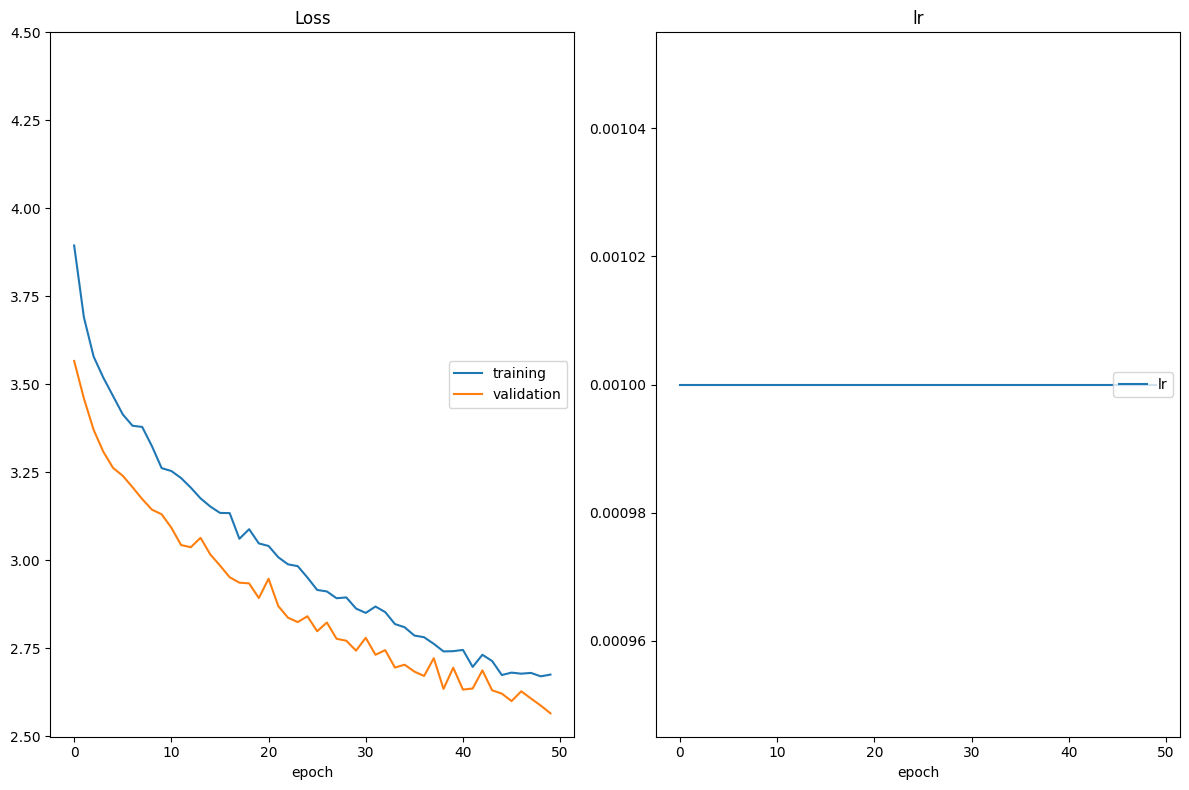

In [4]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# Get the data loaders using batch_size and valid_size defined in the previous
data_loaders = get_data_loaders(batch_size, valid_size, num_workers=-1)

model = MyModel(n_classes, dropout)

# Get the optimizer and loss
optimizer = get_optimizer(model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay)
loss = get_loss()

optimize(data_loaders, 
         model, 
         optimizer, 
         loss, 
         n_epochs, 
         save_path="checkpoints/best_val_loss.pt", 
         interactive_tracking=True
)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 6: testing against the Test Set

> 

In [7]:
# Load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(n_classes=n_classes, dropout=dropout)

# Load the weights that gave the best validation accuracy
model.load_state_dict(torch.load("checkpoints/best_val_loss.pt"))

# Evaluate the model on the test set
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:06<00:00,  2.99it/s]

Test Loss: 2.443679


Test Accuracy: 40% (512/1250)


2.4436792075634

In [17]:
from torchsummary import summary

# before adding another cnn block
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         LeakyReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
         LeakyReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
       BatchNorm2d-7           [-1, 32, 56, 56]              64
            Conv2d-8           [-1, 64, 56, 56]          18,496
         LeakyReLU-9           [-1, 64, 56, 56]               0
        MaxPool2d-10           [-1, 64, 28, 28]               0
          Dropout-11                [-1, 50176]               0
           Linear-12                  [-1, 256]      12,845,312
        LeakyReLU-13                  [-1, 256]               0
      BatchNorm1d-14                  [

In [30]:
# test new architecture
!pytest -vv src/model.py

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 1 item

src/model.py::test_model_construction PASSED                             [100%]

============================== warnings summary ===============================
src/model.py::test_model_construction
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
    interpolation: int = Image.BILINEAR,

src/model.py::test_model_construction
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:286: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10

### hyperparameters tuning

In [2]:
batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
n_epochs = 30          # number of epochs for training
n_classes = 50         # number of classes. Do not change this
dropout = 0.3          # dropout for our model
learning_rate = 5e-3   # Learning rate for SGD (or Adam)
opt = 'adam'           # optimizer. 'sgd' or 'adam'
weight_decay = 1e-4    # regularization. Increase this to combat overfitting

In [42]:
# import src.model as model
# reload(model)
from src.model import MyModel
# new architecture
model = MyModel(n_classes, dropout)
summary(model.cuda(), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         LeakyReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
         LeakyReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
       BatchNorm2d-7           [-1, 32, 56, 56]              64
            Conv2d-8           [-1, 64, 56, 56]          18,496
         LeakyReLU-9           [-1, 64, 56, 56]               0
        MaxPool2d-10           [-1, 64, 28, 28]               0
           Conv2d-11          [-1, 128, 28, 28]          73,856
        LeakyReLU-12          [-1, 128, 28, 28]               0
        MaxPool2d-13          [-1, 128, 14, 14]               0
          Dropout-14                [-1

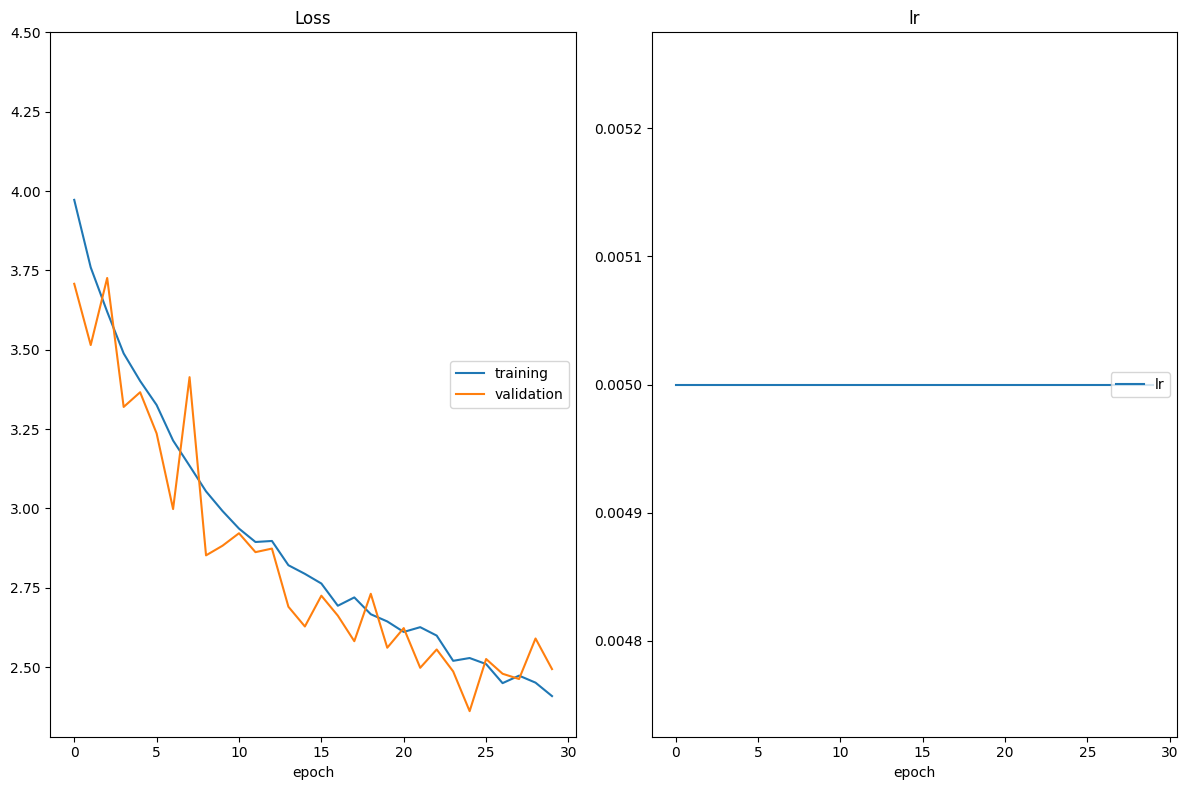

In [44]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel


# Get the optimizer and loss
optimizer = get_optimizer(model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay)
loss = get_loss()

optimize(data_loaders, 
         model, 
         optimizer, 
         loss, 
         n_epochs, 
         save_path="checkpoints/best_val_loss_01.pt", 
         interactive_tracking=True
)

### Testing new architecture and hyperparameters

In [45]:
model = MyModel(n_classes=n_classes, dropout=dropout)

# Load the weights that gave the best validation accuracy
model.load_state_dict(torch.load("checkpoints/best_val_loss_01.pt"))

# Evaluate the model on the test set
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:06<00:00,  3.01it/s]

Test Loss: 2.163006


Test Accuracy: 44% (561/1250)


2.163005834817887

### Train more epochs on the last checkpoint
experimenting with reducing learning rate and epochs

In [2]:
batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
n_epochs = 25          # number of epochs for training
n_classes = 50         # number of classes. Do not change this
dropout = 0.3          # dropout for our model
learning_rate = 4e-3   # Learning rate for SGD (or Adam)
opt = 'adam'           # optimizer. 'sgd' or 'adam'
weight_decay = 1e-4    # regularization. Increase this to combat overfitting
# reduce learning rate and epochs

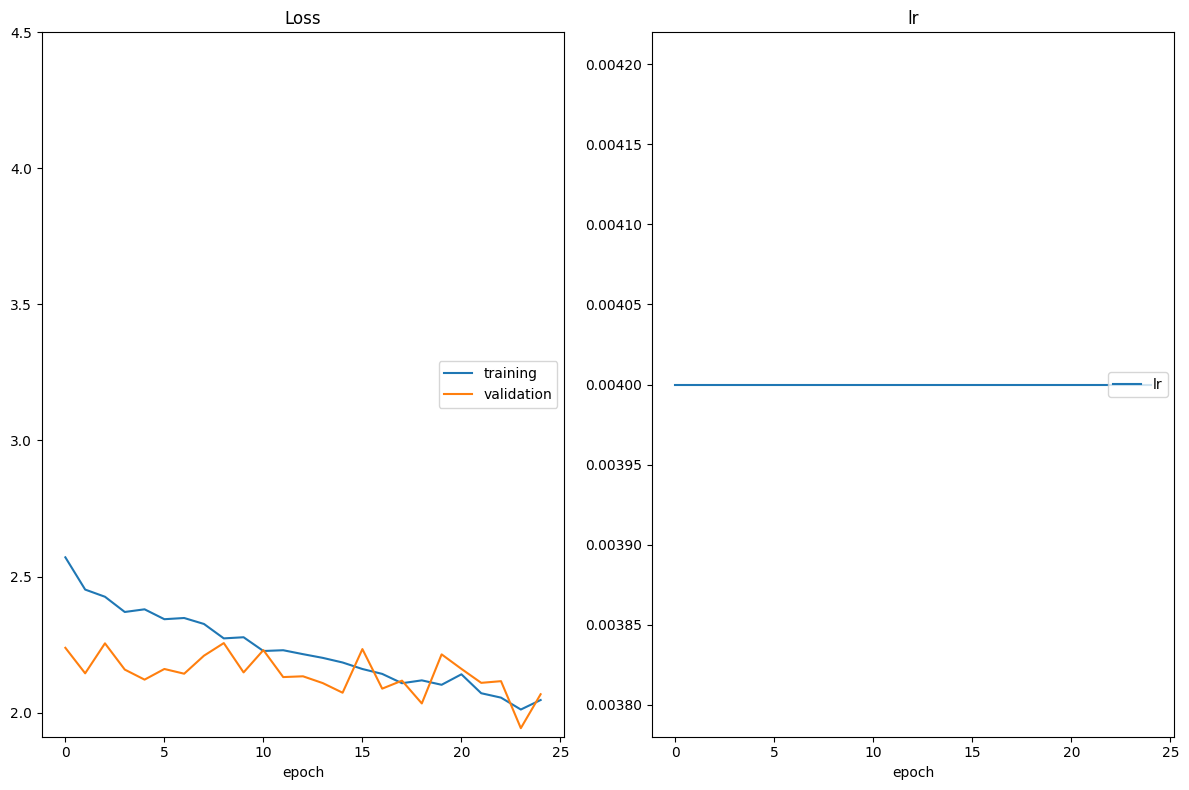

In [3]:
import torch
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# Get the data loaders using batch_size and valid_size defined in the previous
data_loaders = get_data_loaders(batch_size, valid_size, num_workers=-1)

model = MyModel(n_classes=n_classes, dropout=dropout)

# Load the weights that gave the best validation accuracy
model.load_state_dict(torch.load("checkpoints/best_val_loss_01.pt"))

# Get the optimizer and loss
optimizer = get_optimizer(model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay)
loss = get_loss()

## added mlflow tracking
optimize(data_loaders, 
         model, 
         optimizer, 
         loss, 
         n_epochs, 
         save_path="checkpoints/best_val_loss_02.pt", 
         interactive_tracking=True
)

In [5]:
from src.train import one_epoch_test

model = MyModel(n_classes=n_classes, dropout=dropout)

# Load the weights that gave the best validation accuracy
model.load_state_dict(torch.load("checkpoints/best_val_loss_02.pt"))

# Evaluate the model on the test set
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:03<00:00,  5.06it/s]

Test Loss: 1.874495


Test Accuracy: 52% (654/1250)


1.8744949340820314

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 7: Export using torchscript

In [16]:
!pytest -vv src/predictor.py

============================= test session starts =============================
platform win32 -- Python 3.10.13, pytest-7.4.2, pluggy-1.3.0 -- C:\Users\Medhat\Anaconda3\envs\torch\python.exe
cachedir: .pytest_cache
rootdir: C:\Dev\ai\udacity\LandmarkClassifier
plugins: anyio-4.0.0
collecting ... collected 1 item

src/predictor.py::test_model_construction PASSED                         [100%]

============================== warnings summary ===============================
..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242
  C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:242: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
    interpolation: int = Image.BILINEAR,

..\..\..\..\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torchvision\transforms\_functional_pil.py:286
  C:\Users\Medhat\Anaconda3\envs\t

In [22]:
import torch
from src.data import get_data_loaders, compute_mean_and_std
from src.model import MyModel
from src.predictor import Predictor
data_loaders = get_data_loaders()

# First let's get the class names from our dataloader
class_names = data_loaders['train'].dataset.classes

# Then we transfer the model to cpu for inference
model = MyModel(n_classes=len(class_names), dropout=0.3).cpu()

# load the best weights
model.load_state_dict(torch.load("checkpoints/best_val_loss_02.pt", map_location='cpu'))

# Lets wrap our model using predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean=mean, std=std).cpu()

# Export
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [23]:
import torch

model_reloaded = torch.jit.load("checkpoints/original_exported.pt")

In [24]:
from src.predictor import predictor_test

pred, truth, _ = predictor_test(data_loaders['test'], model_reloaded)

Testing:   0%|                                 | 1/1250 [00:00<06:40,  3.12it/s]C:\Users\Medhat\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\module.py:1501: UserWarning: operator () profile_node %387 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at ..\third_party\nvfuser\csrc\graph_fuser.cpp:108.)
  return forward_call(*args, **kwargs)
code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Accuracy: 0.5168


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

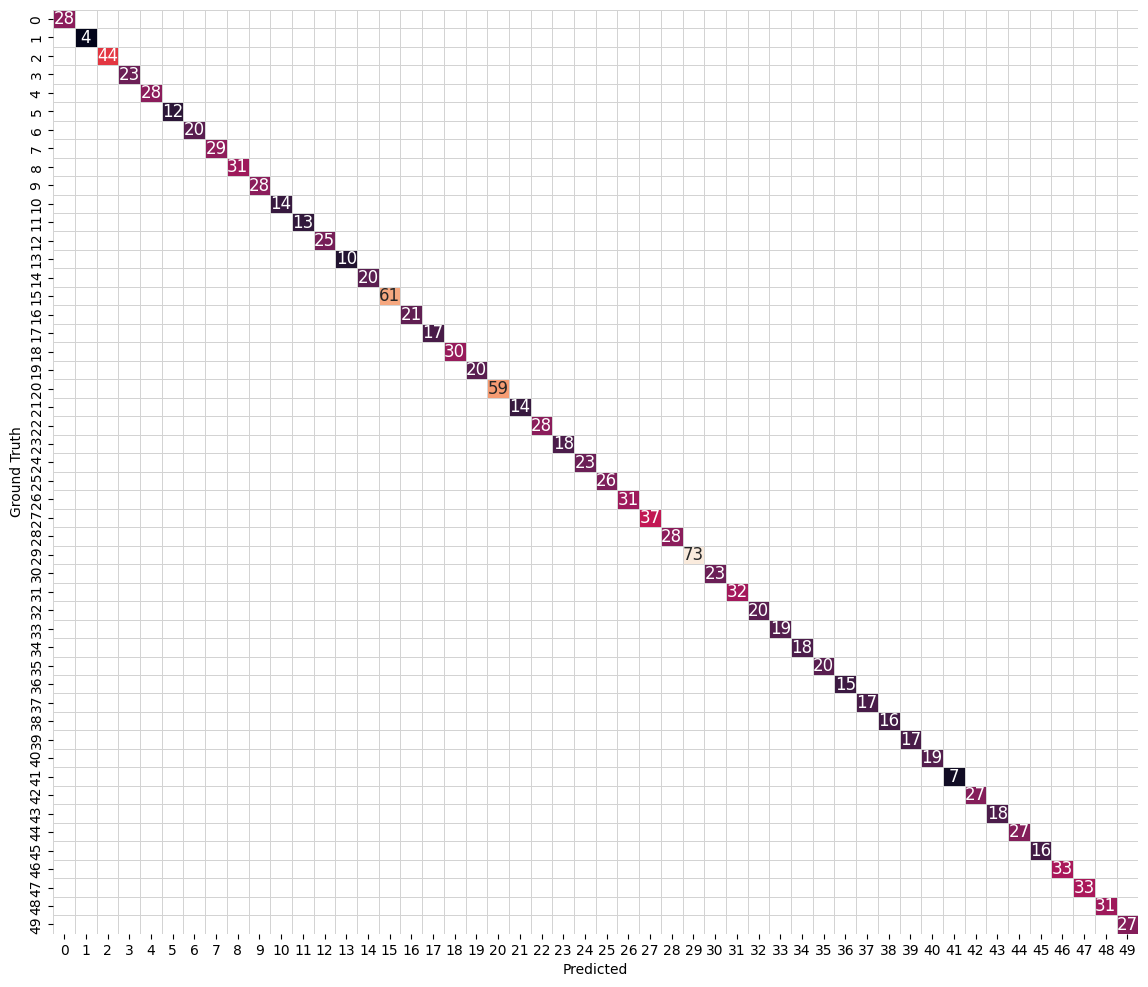

In [28]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)